In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from riskyneuroarousal.utils.load_data import (load_behavioral_data, load_pupil_data)
%load_ext rpy2.ipython

In [2]:
behavior = load_behavioral_data(min_RT = 0.2)
pupil_data = load_pupil_data()
data = pupil_data.merge(behavior, on=["sub", "trial"])
data["pupil_size"] = data["ps_preprocessed"] - data["baseline"]

In [3]:
%%R -i data
library(mgcv)
library(lme4)
library(lmerTest)
library(dplyr)
library(broom.mixed)

Loading required package: nlme
This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.
Loading required package: Matrix

Attaching package: ‘lme4’

The following object is masked from ‘package:nlme’:

    lmList


Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step


Attaching package: ‘dplyr’

The following object is masked from ‘package:nlme’:

    collapse

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [ ]:
%%R -o residual_pupil
# loop through timebins
residual_pupil <- data.frame()
# Create a copy of data with sub, loss_over_gain, gain, loss, condition

for (tb in unique(data$timebin)) {
    # for each timebin, run a linear mixed effects model of ps_preprocessed
    model = lmer(pupil_size ~ RT*condition + blink*condition + (1| sub) + (-1 + RT|sub) + (-1 + blink | sub), data=data[data$timebin == tb, ])

    # Gather results
    residuals <- residuals(model)
    results <- data.frame(pupil_residual = residuals, 
                        timebin = tb, 
                        sub = data[data$timebin == tb, "sub"], 
                        gain = data[data$timebin == tb, "gain"], 
                        loss = data[data$timebin == tb, "loss"], 
                        condition = data[data$timebin == tb, "condition"], 
                        RT = data[data$timebin == tb, "RT"],
                        accept = data[data$timebin == tb, "accept"])
    residual_pupil <- rbind(residual_pupil, results)
}

boundary (singular) fit: see help('isSingular')
In addition: Warning messages:
1: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
  Model failed to converge with max|grad| = 0.00274893 (tol = 0.002, component 1)
2: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
  Model failed to converge with max|grad| = 0.00242003 (tol = 0.002, component 1)
3: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
  Model failed to converge with max|grad| = 0.00278892 (tol = 0.002, component 1)


In [23]:
def gain_quantile(gain, condition):
    description = "Unknown"
    if condition == 'equalRange':
        if gain >= 5 and gain < 10:
            description = "Gain 5-9"
        elif gain >= 10 and gain <= 15:
            description = "Gain 10-15"
        else:
            description = "Gain 16-20"
    if condition == 'equalIndifference':
        if gain >= 10 and gain < 20:
            description = "Gain 10-18"
        elif gain >= 20 and gain <= 30:
            description = "Gain 20-30"
        else:
            description = "Gain 32-40"
    return description 

def loss_quantile(loss):
    description = "Unknown"
    if loss >= 5 and loss < 10:
        description = "Loss 5-9"
    elif loss >= 10 and loss <= 15:
        description = "Loss 10-15"
    else:
        description = "Loss 16-20"
    return description

In [39]:
gain_names = residual_pupil[["gain", "condition"]].apply(lambda x: gain_quantile(x["gain"], x["condition"]), axis=1)
loss_names = residual_pupil["loss"].apply(lambda x: loss_quantile(x))
residual_pupil["gain_quantile"] = gain_names
residual_pupil["loss_quantile"] = loss_names

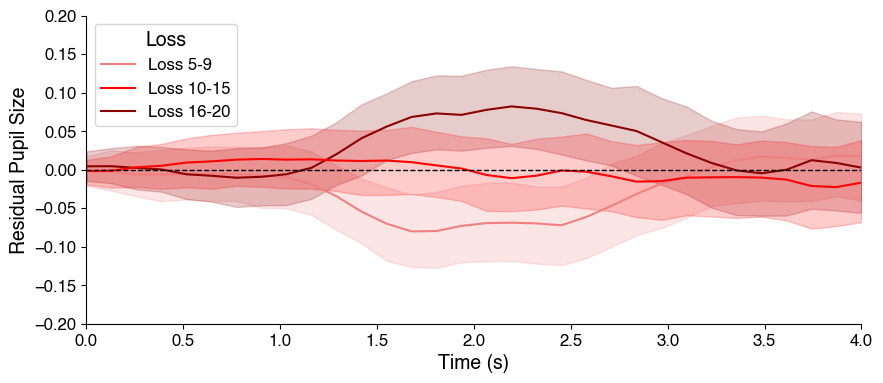

In [56]:
plt.rcParams["font.family"] = "Helvetica"
color_palette = {'Loss 5-9': 'lightcoral', 'Loss 10-15': 'red', 'Loss 16-20': 'darkred'}
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=residual_pupil.query("condition == 'equalIndifference'"), x="timebin", y="pupil_residual", hue="loss_quantile", palette=color_palette, ax=ax)
# remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
# Axis labels, and size
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Residual Pupil Size", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlim(0, 4)
ax.set_ylim(-0.2, 0.2)
# size of legend
handles, labels = ax.get_legend_handles_labels()
order = ['Loss 5-9', 'Loss 10-15', 'Loss 16-20']
handles = [handles[labels.index(o)] for o in order]
plt.legend(handles=handles, title="Loss", fontsize=12, title_fontsize=14)
# horizontal line at 0
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()

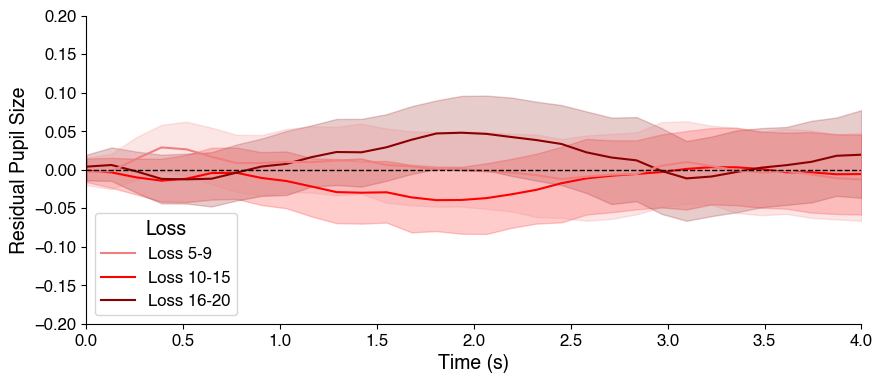

In [57]:
plt.rcParams["font.family"] = "Helvetica"
color_palette = {'Loss 5-9': 'lightcoral', 'Loss 10-15': 'red', 'Loss 16-20': 'darkred'}
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=residual_pupil.query("condition == 'equalRange'"), x="timebin", y="pupil_residual", hue="loss_quantile", palette=color_palette, ax=ax)
# remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
# Axis labels, and size
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Residual Pupil Size", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlim(0, 4)
ax.set_ylim(-0.2, 0.2)
# size of legend
plt.legend(title="Loss", fontsize=12, title_fontsize=14)
# Set order of legend
handles, labels = ax.get_legend_handles_labels()
order = ['Loss 5-9', 'Loss 10-15', 'Loss 16-20']
handles = [handles[labels.index(o)] for o in order]
plt.legend(handles=handles, title="Loss", fontsize=12, title_fontsize=14)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()

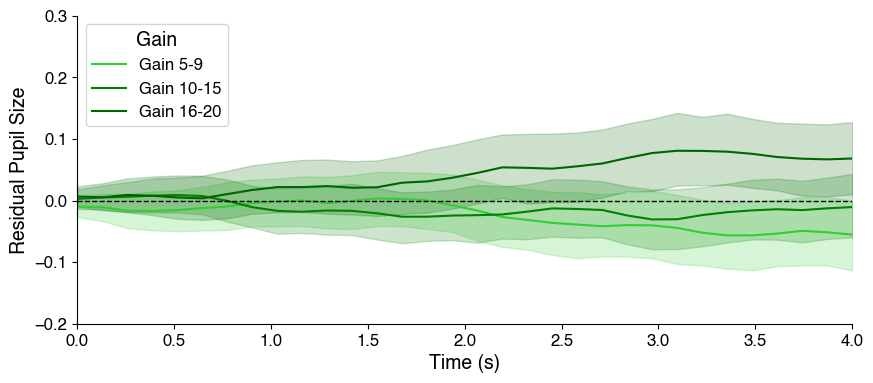

In [64]:
plt.rcParams["font.family"] = "Helvetica"
color_palette = {'Gain 5-9': 'limegreen', 'Gain 10-15': 'green', 'Gain 16-20': 'darkgreen'}
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=residual_pupil.query("condition == 'equalRange'"), x="timebin", y="pupil_residual", hue="gain_quantile", palette=color_palette, ax=ax)
# remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
# Axis labels, and size
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Residual Pupil Size", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlim(0, 4)
ax.set_ylim(-0.2, 0.30)
# size of legend
plt.legend(title="Gain", fontsize=12, title_fontsize=14)
# Set order of legend
handles, labels = ax.get_legend_handles_labels()
order = ['Gain 5-9', 'Gain 10-15', 'Gain 16-20']
handles = [handles[labels.index(o)] for o in order]
plt.legend(handles=handles, title="Gain", fontsize=12, title_fontsize=14)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()

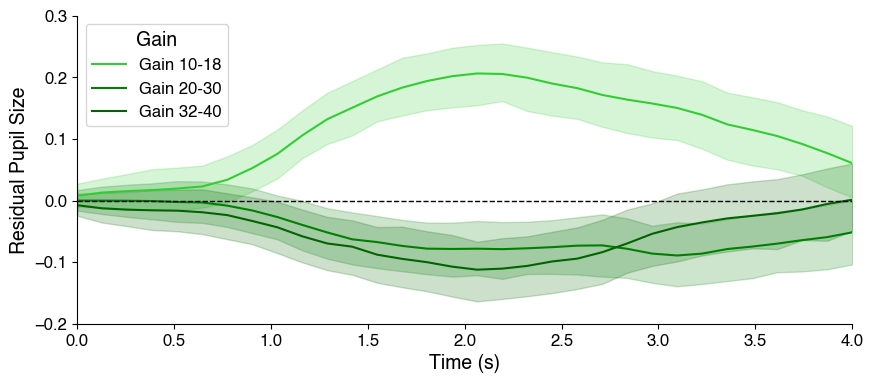

In [63]:
plt.rcParams["font.family"] = "Helvetica"
color_palette = {'Gain 10-18': 'limegreen', 'Gain 20-30': 'green', 'Gain 32-40': 'darkgreen'}
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=residual_pupil.query("condition == 'equalIndifference'"), x="timebin", y="pupil_residual", hue="gain_quantile", palette=color_palette, ax=ax)
# remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
# Axis labels, and size
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Residual Pupil Size", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlim(0, 4)
ax.set_ylim(-0.2, 0.30)
# size of legend
plt.legend(title="Gain", fontsize=12, title_fontsize=14)
# Set order of legend
handles, labels = ax.get_legend_handles_labels()
order = ['Gain 10-18', 'Gain 20-30', 'Gain 32-40']
handles = [handles[labels.index(o)] for o in order]
plt.legend(handles=handles, title="Gain", fontsize=12, title_fontsize=14)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()